In [53]:
import numpy as np
import math
import scipy as Sci
from scipy import integrate
from scipy import linalg
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
# Constants
t_f = 15
V_max = 0.5
om_max = 1

# Initial conditions
x_0 = 0
y_0 = 0
V_0 = V_max
th_0 = -np.pi/2

# Final conditions
x_f = 5
y_f = 5
V_f = V_max
th_f = -np.pi/2

## Problem 1

In [60]:
# Solve Linear equations:
t_0 = 0
phi_0 = np.array([1, t_0, t_0**2, t_0**3])
phi_f = np.array([1, t_f, t_f**2, t_f**3])

A = np.array([
[ phi_0[0], phi_0[1], phi_0[2], phi_0[3], 0, 0, 0, 0],
[ phi_f[0], phi_f[1], phi_f[2], phi_f[3], 0, 0, 0, 0],
[ 0, phi_0[0], 2*phi_0[1], 3*phi_0[2], 0, 0, 0, 0],
[ 0, phi_f[0], 2*phi_f[1], 3*phi_f[2], 0, 0, 0, 0],
[ 0, 0, 0, 0, phi_0[0], phi_0[1], phi_0[2], phi_0[3]],
[ 0, 0, 0, 0, phi_f[0], phi_f[1], phi_f[2], phi_f[3]],
[ 0, 0, 0, 0, 0, phi_0[0], 2*phi_0[1], 3*phi_0[2]],
[ 0, 0, 0, 0, 0, phi_f[0], 2*phi_f[1], 3*phi_f[2]],
])

b = np.array([[0, 5, V_0*np.cos(th_0), V_f*np.cos(th_f), 0, 5, V_0*np.sin(th_0), V_f*np.sin(th_f)]]).T

X = linalg.solve(A,b)

dt = 0.005
N = int (t_f/dt)
t = dt*np.array(range(N+1)) # t[0],....,t[N]
t = t.T
data = np.zeros((N+1,9))

In [9]:
xTraj = np.zeros([len(t),1]).T
yTraj = np.zeros([len(t),1]).T
thTraj = np.zeros([len(t),1]).T
dXdT = np.zeros([len(t),1]).T
dYdT = np.zeros([len(t),1]).T
ddXdT = np.zeros([len(t),1]).T
ddYdT = np.zeros([len(t),1]).T
VTraj = np.zeros([len(t),1]).T
omega = np.zeros([len(t),1]).T

tStack = np.vstack([np.zeros(t.shape),np.ones(t.shape),t,t**2,t**3])

xTraj[:] = np.dot(X[:4].T,tStack[1:])
yTraj[:] = np.dot(X[4:].T,tStack[1:])

dXdT[0,1:] = np.diff(xTraj)/dt
dYdT[0,1:] = np.diff(yTraj)/dt
thTraj[0,:] = np.arctan2(dYdT,dXdT)
thTraj[0,0] = th_0
omega[0,1:] = np.diff(thTraj)/dt
omega[0,1] = omega[0,2]
omega[0,0] = omega[0,1]

ddXdT[0,1:] = np.diff(dXdT)/dt
ddYdT[0,1:] = np.diff(dYdT)/dt

VTraj[0,:] = np.sqrt(dXdT**2 + dYdT**2)
VTraj[0,0] = V_0

data = np.vstack([xTraj,yTraj,thTraj,VTraj,omega,dXdT,dYdT,ddXdT,ddYdT]).T
data.shape

(3001, 9)

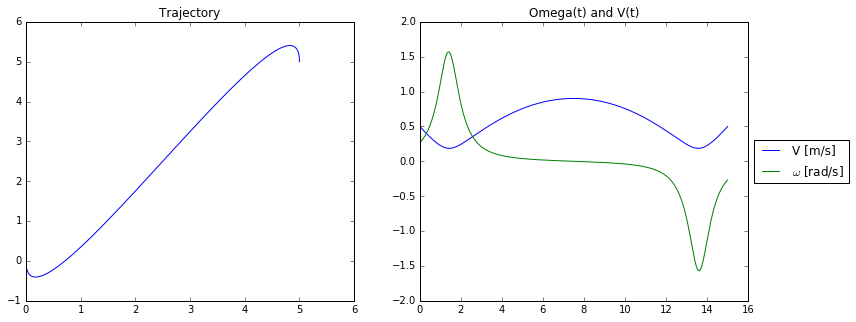

In [10]:
plt.figure(figsize = [20,5])
plt.subplot(1,3,1)
plt.plot(xTraj[0,:], yTraj[0,:])
plt.title('Trajectory')

plt.subplot(1,3,2)
plt.plot(t, VTraj[0,:])
plt.hold=True
plt.plot(t,omega[0,:])
plt.title('Omega(t) and V(t)')
plt.legend(['V [m/s]', '$\omega$ [rad/s]'],loc='center left', bbox_to_anchor=(1,0.5))

plt.show()

 ## Problem 2 - Rescaling

In [70]:
## calculate s(t)
s = np.zeros(xTraj.shape)
s[0,1:] = integrate.cumtrapz(VTraj,dx=dt)

dSdt = np.zeros(s.shape)
dSdt[0,1:] = np.diff(s)/dt
V_s = np.zeros(s.shape)
omega_s = np.zeros(s.shape)
V_s[0,1:] = VTraj[0,1:]/dSdt[0,1:]
omega_s[0,1:] = omega[0,1:]/dSdt[0,1:]


## Calculate new dt(s) to stretch velocity and omega vectors
dtdS = np.ones(s.shape)*dt

# RESCALE dt proportional to V/Vmax where V >= Vmax
dtdS[VTraj >= V_max] = dtdS[VTraj >= V_max]*VTraj[VTraj >= V_max] / V_max
# RESCALE dt proportional to om/om_max where om >= om_max
dtdS[abs(omega) >= om_max] = dtdS[abs(omega) >= om_max]*abs(omega[abs(omega) >= om_max]) / om_max

# rescaled time history
t_s = np.cumsum(dtdS,axis=1)

# calculate adjusted ds/dt. sDot will be different than dSdt because the 'dt's are no longer uniform
sDot = np.zeros(s.shape)
sDot[0,1:] = np.diff(s)/dtdS[0,1:] 


# Rescaled V(t) and Omega(t)
V_t = sDot*V_s
omega_t = sDot*omega_s

# Interpolate over new time series tF
tF = np.array([np.arange(0,t_s[0,-1],dt)])
fV = interp1d(t_s[0,:],V_t[0,:]) # interpolation function for Velocity
fOmega = interp1d(t_s[0,:],omega_t[0,:]) # interpolation function for Omega
fS = interp1d(t_s[0,:],s[0,:])

# interpolated Rescaled Velocity
VF = np.zeros(tF.shape)
VF[0,1:] = fV(tF[0,1:])
# interpolated Rescaled Omega
omegaF = np.zeros(tF.shape)
omegaF[0,1:] = fOmega(tF[0,1:])
# interpolated S
sF = np.zeros(tF.shape)
sF[0,1:] = fS(tF[0,1:])

# ReCalculate trajectory

xF = np.zeros(tF.shape)
yF = np.zeros(tF.shape)
thF = np.zeros(tF.shape)
dXFdT = np.zeros(tF.shape)
dYFdT = np.zeros(tF.shape)
ddXFdT = np.zeros(tF.shape)
ddYFdT = np.zeros(tF.shape)
# VF = np.zeros(tF.shape)
# omegaF = np.zeros(tF.shape)

thF[0,:] = integrate.cumtrapz(omegaF,dx=dt,initial=0) + th_0

dXFdT[0,:] = VF*np.cos(thF)
dYFdT[0,:] = VF*np.sin(thF)
dXFdT[0,0] = V_0*np.cos(th_0)
dYFdT[0,0] = V_0*np.sin(th_0)

ddXFdT[0,1:] = np.cos(thF[0,1:])*np.diff(VF)/dt - omegaF[0,:1]*VF[0,:1]*np.sin(thF[0,1:])
ddXFdT[0,1:] = np.sin(thF[0,1:])*np.diff(VF)/dt + omegaF[0,:1]*VF[0,:1]*np.cos(thF[0,1:])
# I think the end (not the beginning) should be padded with zeros

xF[0,1:] = integrate.cumtrapz(dXFdT,dx=dt)
yF[0,1:] = integrate.cumtrapz(dYFdT,dx=dt)

# print xF.shape
# print yF.shape
# print thF.shape
# print VF.shape
# print omegaF.shape
# print dXFdT.shape
# print dYFdT.shape
# print ddXFdT.shape
# print ddYFdT.shape

data_scaled = np.vstack([xF,yF,thF,VF,omegaF,dXFdT,dYFdT,ddXFdT,ddYFdT]).T
data_scaled.shape

t_scaled = tF.T
s_scaled = sF.T
s = s[0,:]

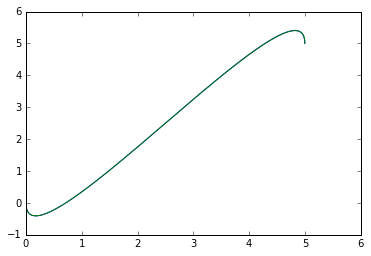

In [22]:
plt.figure()
plt.hold=True
plt.plot(xF[0,:],yF[0,:])
plt.plot(xTraj[0,:],yTraj[0,:])
plt.show()

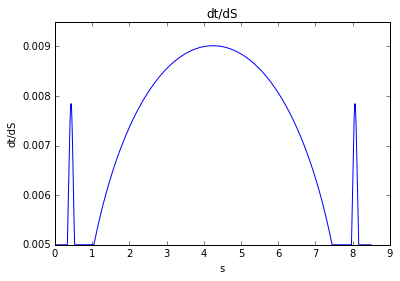

In [20]:

# plot rescaled dt/ds
plt.figure()

plt.plot(s[0,:],dtdS[0,:])
plt.title('dt/dS')
plt.xlabel('s')
plt.ylabel('dt/dS')

plt.show()

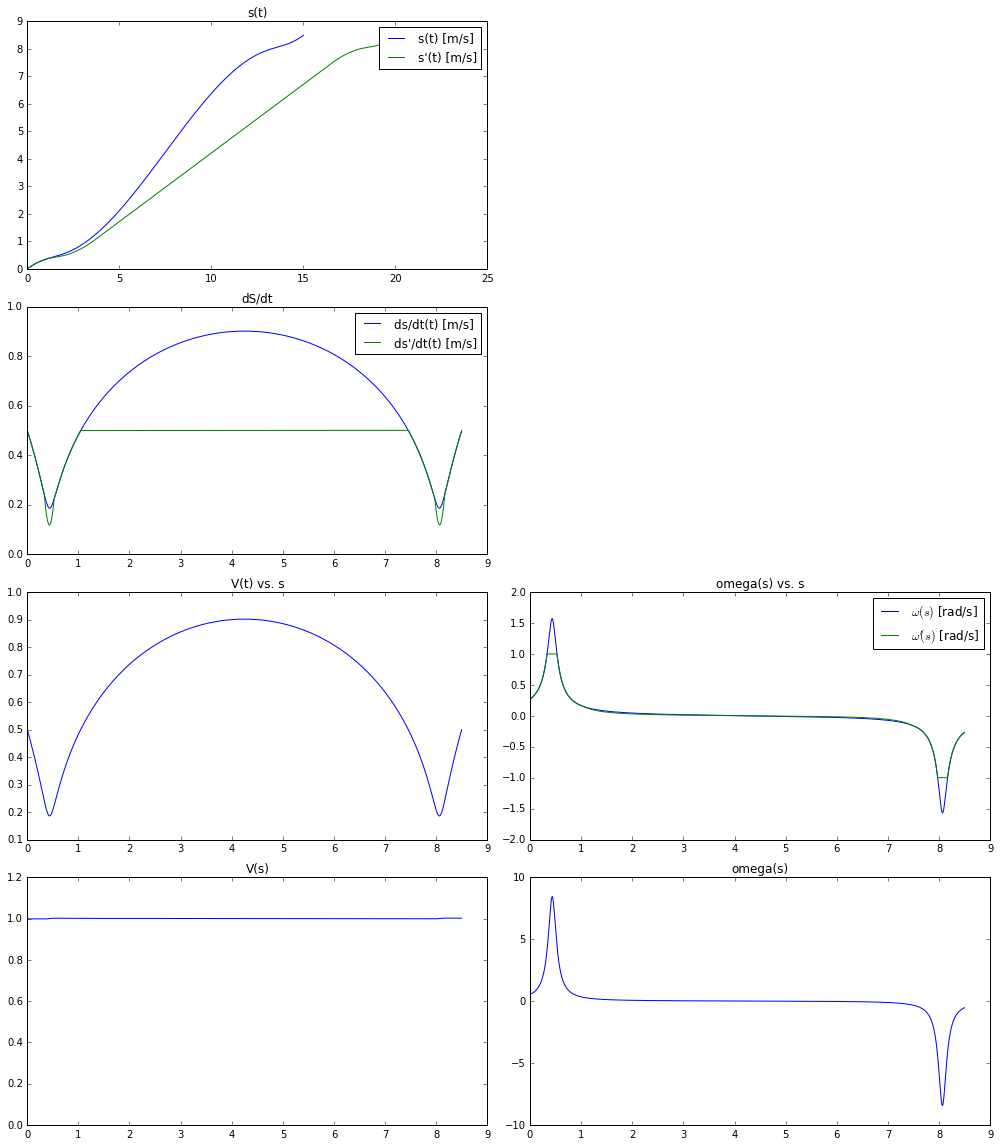

In [21]:
plt.figure(figsize = [14,16])
# t vs. s
plt.subplot(4,2,1)
plt.hold=True
plt.plot(t,s.T) # old
plt.plot(t_s[0,:],s[0,:]) # new
plt.legend(['s(t) [m/s]', 's\'(t) [m/s]'])
plt.title('s(t)')

# s vs ds/dt
plt.subplot(4,2,3)
plt.hold=True
plt.plot(s[0,:],dSdt[0,:]) #old
plt.plot(s[0,:],sDot[0,:]) #new
plt.legend(['ds/dt(t) [m/s]', 'ds\'/dt(t) [m/s]'])
plt.title('dS/dt')

# Velocity
# s vs V(t)
plt.subplot(4,2,5)
plt.plot(s[0,:],VTraj[0,:])
plt.title('V(t) vs. s')

# s vs V(s)
# s vs omega(s)
plt.subplot(4,2,7)
plt.hold=True
plt.plot(s[0,:],V_s[0,:])
plt.title('V(s)')

# Omega
# s vs omega(t)
plt.subplot(4,2,6)
plt.hold=True
plt.plot(s[0,:],omega[0,:])
plt.plot(s[0,:],omega_t[0,:])
plt.legend(['$\omega(s)$ [rad/s]', '$\omega\' (s)$ [rad/s]'])
plt.title('omega(s) vs. s')

# s vs omega(s)
plt.subplot(4,2,8)
plt.plot(s[0,:],omega_s[0,:])
plt.title('omega(s)')

plt.tight_layout()
plt.show()

## Plot (1) trajectory (x(t),y(t))

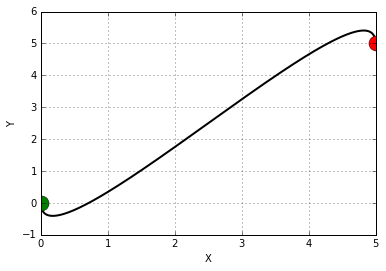

In [67]:
plt.figure()
plt.plot(data_scaled[:,0], data_scaled[:,1],'k-',linewidth=2)
plt.grid('on')
plt.plot(x_0,y_0,'go',markerfacecolor='green',markersize=15)
plt.plot(x_f,y_f,'ro',markerfacecolor='red', markersize=15)
plt.xlabel('X'); plt.ylabel('Y')

## Plot (2) arc-length s(t) for the original and scaled trajectories

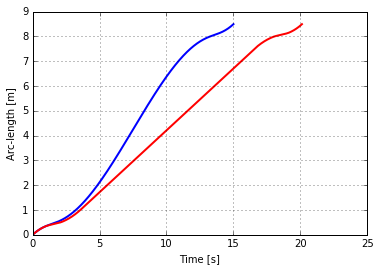

In [72]:
plt.figure()
plt.plot(t,s,'b-',linewidth=2)
plt.grid('on')
plt.plot(t_scaled,s_scaled,'r-',linewidth=2)
plt.xlabel('Time [s]')
plt.ylabel('Arc-length [m]')

## Plot (3) control history for the original and scaled trajectories

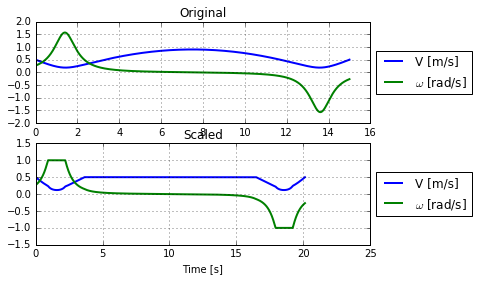

In [71]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, data[:,3:5],linewidth=2)
plt.grid('on')
plt.xlabel('Time [s]')
plt.legend(['V [m/s]', '$\omega$ [rad/s]'],loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Original')

plt.subplot(2,1,2)
plt.plot(t_scaled,data_scaled[:,3:5],linewidth=2)
plt.grid('on')
plt.xlabel('Time [s]')
plt.legend(['V [m/s]', '$\omega$ [rad/s]'],loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Scaled')

## Problem 3

In [ ]:
## forward
x_0 = 6
y_0 = 9
th_0 = -1.5
t_f = 50
## reverse - turns around to drive forward
x_0 = 5
y_0 = 2
th_0 = -np.pi/2
t_f = 100
## Parallel parking
x_0 = 8
y_0 = 5
th_0 = -np.pi/2
t_f = 100


## Problem 4